In [32]:
import sys
import json
from tqdm import tqdm
import re
import pandas as pd
from collections import defaultdict
from libindic import inexactsearch
import pandas as pd
import pickle as pkl
from editdistance import eval as ed
from fuzzywuzzy import fuzz
import numpy as np
from random import shuffle
import string
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_score(translated_infobox , actual_infobox):
    inst = inexactsearch.InexactSearch()
    markings = defaultdict(list)
    all_keys = list(translated_infobox.keys()) + list(actual_infobox.keys())
    translated_infobox = { key.strip() : val for key , val in translated_infobox.items()}
    actual_infobox = { key.strip() : val for key , val in actual_infobox.items()}

    for key in translated_infobox.keys():
        for key2 in actual_infobox.keys():
            if fuzz.token_sort_ratio(key , key2) >= 80:
                if not translated_infobox[key]:
                    markings['S'].append(key)
                    continue 
                elif not actual_infobox[key2]:
                    continue
                skip = False
                try :
                    for let in actual_infobox[key2]:
                        if let in string.ascii_letters:
                            skip = True
                            break
                    val = inst.compare(translated_infobox[key] , actual_infobox[key2])
                except :
                    skip = False
                    val = 0
                if skip : continue
                if val >= 0.6 :
                    markings['C'].append({key : val})
                else :
                    markings['S'].append({key : val})
                break
    for key2 in actual_infobox.keys():
        for key in translated_infobox.keys():
            if fuzz.token_sort_ratio(key , key2) >= 80:
                break
        else :
            markings['D'].append(key2)
            
    for key in translated_infobox.keys():
        for key2 in actual_infobox.keys():
            if fuzz.token_sort_ratio(key , key2) >= 80:
                break
        else :
            markings['I'].append(key)
    if len(markings['C']) + len(markings['S']) != 0:
        precision = len(markings['C']) / (len(markings['C']) + len(markings['S']))
    else : precision = 0
    if (len(markings['C']) + len(markings['S']) + len(markings['D'])) != 0:
        recall = len(markings['C']) / (len(markings['C']) + len(markings['S']) + len(markings['D']))
    else : recall = 0
    return [precision , recall] , markings

In [3]:
def get_results(data):
    overall_score = []
    list_d = [defaultdict(int) for i in range(3)]
    list_i = [defaultdict(int) for i in range(3)]
    keys_score = [defaultdict(lambda : defaultdict(int)) for i in range(3)]
    keys_match = [defaultdict(int) for i in range(2)]
    for ind , entry in enumerate(data) :
        cur_score = []
        for key , val in entry.items():
            for i in range(3):
                if not val[-1] : continue
                score , markings = get_score(val[2-i] , val[-1])
                cur_score.append(score)
                for key in markings['D']:
                    list_d[i][key]+=1
                    keys_score[i][key]['D']+=1
                for key in markings['I']:
                    list_i[i][key]+=1
                    keys_score[i][key]['I']+=1
                for label in ['C' , 'S']:
                    for item in markings[label]:
                        for key2 , val2 in item.items():
                            keys_score[i][key][label]+=1
                            if val2 >= 0.7 :
                                keys_match[0][key2]+=1
                            if val2 >= 0.3:
                                keys_match[1][key2]+=1
        if not cur_score : continue
        overall_score.append(np.array(sum(cur_score , [])))
#         break
    list_d = [ {key : val for key , val in sorted(list_d[i].items() , key = lambda item : item[1] , reverse=True)[:20]} for i in range(3)]
    list_i = [ {key : val for key , val in sorted(list_i[i].items() , key = lambda item : item[1] , reverse=True)[:20]} for i in range(3)]
    df = pd.DataFrame(overall_score , columns=['M1-Precision','M1-Recall','M2-Precision','M2-Recall','Baseline-Precision','Baseline-Recall'])
    for method in keys_score:
        for key , val in method.items():
            den = val['C'] + val['S']
            method[key]['precision'] = val['C'] / (max(1 , den))
            den += val['D']
            method[key]['recall'] = val['C'] / max(1 , den)
    graph_data = {
        'list_d' : list_d,
        'list_i' : list_i,
        'keys_match' : keys_match,
        'keys_score' : keys_score
    }
    return df , graph_data

In [315]:
def prec_rec_graph(df , dataset , names = None , ind = None):
    # set width of bar
    barWidth = 0.25
    
    score_list = []
    if type(df) == pd.core.frame.DataFrame:
        df = list(df.mean())
    for i in range(0,len(df),2):
        prec , recall = df[i] , df[i+1]
        score_list.append(prec * 100)
        score_list.append(recall * 100)
        score_list.append(2*prec*recall / (prec + recall) * 100)
    # set height of bar
    prec = [score_list[i] for i in range(0,len(score_list),3)]
    rec = [score_list[i] for i in range(1,len(score_list)+1,3)]
    f1 = [score_list[i] for i in range(2,len(score_list)+2,3)]

#     print(prec)
#     print(rec)
#     print(f1)
    # Set position of bar on X axis
    r1 = np.arange(len(prec))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Make the plot
    plt.bar(r1, prec, color='#a83232', width=barWidth, edgecolor='white', label='Precision')
    plt.bar(r2, rec, color='#328ba8', width=barWidth, edgecolor='white', label='Recall')
    plt.bar(r3, f1, color='#32a838', width=barWidth, edgecolor='white', label='F1-Score')

    # Add xticks on the middle of the group bars
    methods = ['Method 1', 'Method 2', 'Baseline']
    if ind!=None:
        method_name = methods[ind]
    else : method_name = ""
    plt.xlabel('For ' + dataset + method_name , fontweight='bold')
    if not names:
        plt.xticks([r + barWidth/2 for r in range(len(prec))], methods)
    else :
        plt.xticks([r + barWidth/2 for r in range(len(prec))], names)
    plt.title('Evaluation Results for ' + dataset , fontweight='bold')
    plt.ylabel("Score")
    plt.xlabel("Method Type")
    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [144]:
data = []
with open('people_eval_records.jsonl') as f:
    data = [ json.loads(i) for i in f.readlines()]
print("Number of records for people :" , len(data))
df_people , graph_data_people = get_results(data)
display(df.mean())

Number of records for people : 700


M1-Precision          0.482690
M1-Recall             0.074289
M2-Precision          0.418671
M2-Recall             0.183139
Baseline-Precision    0.390357
Baseline-Recall       0.065681
dtype: float64

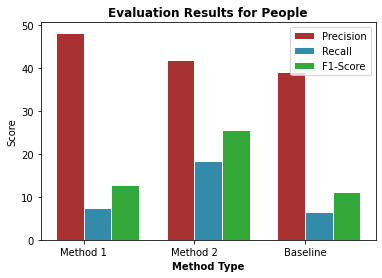

In [316]:
prec_rec_graph(df_people , "People")

In [220]:
data = []
with open('places_eval_records.jsonl') as f:
    data = [ json.loads(i) for i in f.readlines()]
print("Number of records for places :" , len(data))
df_places , graph_data_places = get_results(data)
display(df.mean())

Number of records for places : 400


M1-Precision          0.482690
M1-Recall             0.074289
M2-Precision          0.418671
M2-Recall             0.183139
Baseline-Precision    0.390357
Baseline-Recall       0.065681
dtype: float64

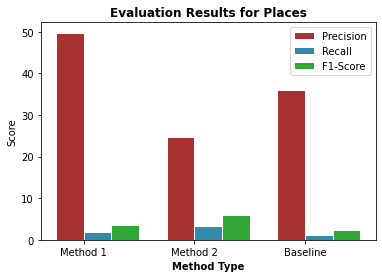

In [317]:
prec_rec_graph(df_places , "Places")

In [134]:
# graph_data = dict with keys [list_d , list_i , keys_match , keys_score ]


# For list_d / list_i / keys_score[i]:
#     [0] = Method1
#     [1] = Method2
#     [2] = Baseline
#     list_d[i] = dictionary with {count where key in actual infobox but not in our infobox} for each key in decreasing order
#     list_i[i] = dictionary with {count where key in our infobox but not in the actual infobox} for each key in decreasing order
#     keys_score[i] = dictionary with {precision , recall , C , S , I , D} for each key

# For keys_match :
#     [0] = match >= 70%
#     [1] = match >= 30%

In [301]:
def percentage_graph(names , score_list , dataset):
    # set width of bar
    barWidth = 0.25
    
    # set height of bar
    per_70 = [ i[0] for i in score_list]
    per_30 = [ i[1] for i in score_list]

    r1 = np.arange(len(per_70))
    r2 = [x + barWidth for x in r1]
    # Make the plot
    plt.bar(r1, per_70, color='#90a832', width=barWidth, edgecolor='white', label='Match > 70%')
    plt.bar(r2, per_30, color='#328ba8', width=barWidth, edgecolor='white', label='Match > 30%')
    # Add xticks on the middle of the group bars
    plt.title('Property wise comparison of percentage match with actual infobox for ' + dataset , fontweight='bold')
    plt.xticks([r + barWidth/2 for r in range(len(per_70))], names , rotation = 'vertical')
    plt.xlabel("Property Name")
    plt.ylabel("Percentage")
    # Create legend & Show graphic
    plt.legend()
    plt.show()

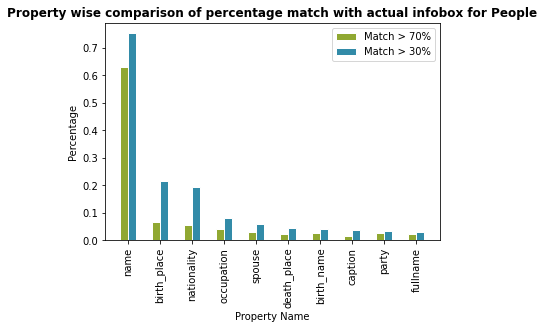

In [312]:
x = defaultdict(list)
keys = [key for  key , val in sorted(graph_data_people['keys_match'][1].items() , key = lambda item : item[1] , reverse = True)[:10]]
for ind , method in enumerate(graph_data_people['keys_match']):
    for key in keys:
        x[key].append(method[key] / 2100)
percentage_graph(list(x.keys()) , list(x.values()) , "People")

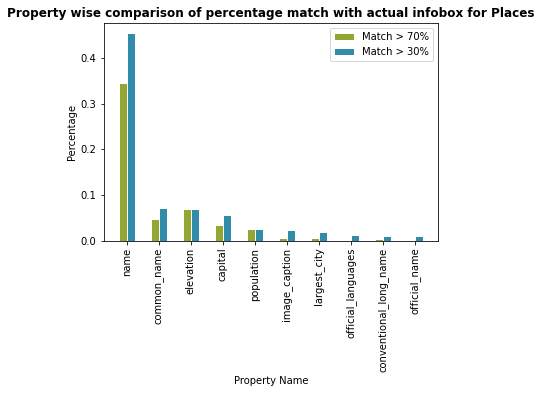

In [311]:
x = defaultdict(list)
keys = [key for  key , val in sorted(graph_data_places['keys_match'][1].items() , key = lambda item : item[1] , reverse = True)[:10]]
for ind , method in enumerate(graph_data_places['keys_match']):
    for key in keys:
        x[key].append(method[key] / 1200)
percentage_graph(list(x.keys()) , list(x.values()) , "Places")